In [1]:
import csv
from scipy import sparse
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
base_path = '/bigstore/binfo/mouse/Brain/Sequencing/Allen_10X_SmartSeqTypes/'
genes = list(pd.read_csv(os.path.join(base_path,'gene_name.csv'),index_col=0)['x'])
cells = list(pd.read_csv(os.path.join(base_path,'sample_name.csv'),index_col=0)['x'])
counts = np.zeros((len(cells),len(genes)),dtype='uint16')
with open(os.path.join(base_path,'matrix.csv')) as f:
    for i, line in tqdm(enumerate(f),total=len(cells)+1,mininterval=0.5):
        if i==0:
            continue
        counts[i-1,:] = line.split(',')[1:]
np.save(os.path.join(base_path,'matrix.npy'),counts)

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|██████████| 1093037/1093037 [3:00:19<00:00, 101.02it/s] 


In [1]:
import csv
from scipy import sparse
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
base_path = '/bigstore/binfo/mouse/Brain/Sequencing/Allen_10X_SmartSeqTypes/'
genes = np.array(list(pd.read_csv(os.path.join(base_path,'gene_name.csv'),index_col=0)['x']))
cells = np.array(list(pd.read_csv(os.path.join(base_path,'sample_name.csv'),index_col=0)['x']))
metadata = pd.read_csv(os.path.join(base_path,'metadata.csv'),index_col=0).loc[cells]
counts = np.load(os.path.join(base_path,'matrix.npy'))
cell_size = np.sum(counts,axis=1)/(10**6)
celltypes = np.array(metadata['cell_type_alias_label'].unique())
celltypes = np.array([i for i in celltypes if isinstance(i,str)])
normcounts = np.stack([(counts[i,:]/cell_size[i]).astype('uint16') for i in tqdm(range(counts.shape[0]),total=counts.shape[0])])
metadata['counts_loc'] = range(normcounts.shape[0]) 
del counts

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|██████████| 1093036/1093036 [03:33<00:00, 5130.24it/s]


In [2]:
Gmu = np.zeros((len(genes),len(celltypes)))
for i,ct in tqdm(enumerate(celltypes),total=len(celltypes)):
    ct_indexes = list(metadata[metadata['cell_type_alias_label']==ct]['counts_loc'])
    if len(ct_indexes)>1:
        Gmu[:,i] = np.mean(normcounts[ct_indexes,:],axis=0)
    else:
        Gmu[:,i] = normcounts[ct_indexes,:]
Gmu_max = np.max(Gmu,axis=1)

100%|██████████| 377/377 [02:19<00:00,  2.69it/s]


In [4]:
Gsep = np.array([np.nanmean(np.abs(Gmu[i,:,None]-Gmu[i,None,:])) for i in tqdm(range(Gmu.shape[0]))])

100%|██████████| 31053/31053 [00:30<00:00, 1002.61it/s]


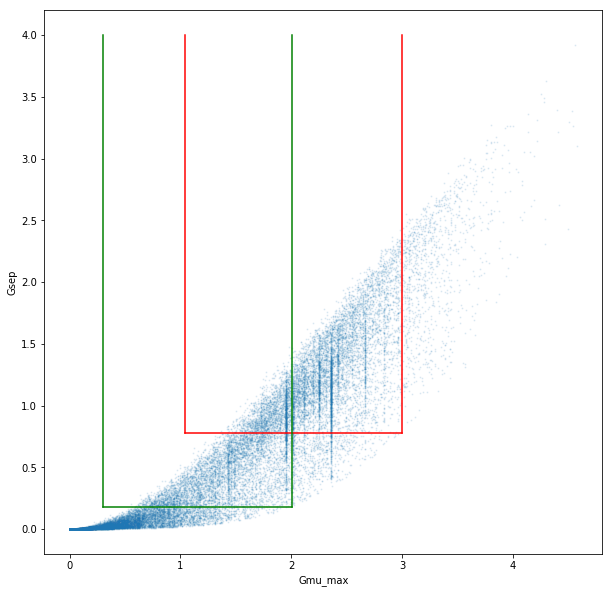

In [5]:
plt.figure(figsize=[10,10])
plt.scatter(np.log10(Gmu_max+1),np.log10(Gsep+1),s=1,alpha=0.1)
d_min = np.log10(10+1)
d_max = np.log10(1000+1)
d_sep = np.log10(5+1)
m_min = np.log10(1+1)
m_max = np.log10(100+1)
m_sep = np.log10(0.5+1)
plt.plot([d_min,d_max],[d_sep,d_sep],c='r')
plt.plot([d_min,d_min],[d_sep,4],c='r')
plt.plot([d_max,d_max],[d_sep,4],c='r')
plt.plot([m_min,m_max],[m_sep,m_sep],c='g')
plt.plot([m_min,m_min],[m_sep,4],c='g')
plt.plot([m_max,m_max],[m_sep,4],c='g')
plt.xlabel('Gmu_max')
plt.ylabel('Gsep')
plt.show()

In [6]:
filtered_genes = np.array(genes)[(Gmu_max>10)&(Gmu_max<1000)&(Gsep>5)]
pd.Series(filtered_genes).to_csv(os.path.join(base_path,'dredfish_filtered_genes.csv'),index=False)
print(len(filtered_genes))

9711


/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [7]:
merfish_filtered_genes = np.array(genes)[(Gmu_max>1)&(Gmu_max<100)&(Gsep>0.5)]
pd.Series(merfish_filtered_genes).to_csv(os.path.join(base_path,'merfish_filtered_genes.csv'),index=False)
print(len(merfish_filtered_genes))

8124


/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [16]:
"""
Deal with leafs with less than 10 cells
"""

In [ ]:
import json
with open(os.path.join(base_path,'dend.json')) as f:
    dend = json.load(f)
def find_next_nodes(node):
    if 'leaf_attributes' in node.keys():
        A = None
        B = None
        C = node['leaf_attributes'][0]['original_label']
        H = node['leaf_attributes'][0]['height']
        Children = []
    elif 'node_attributes' in node.keys():
        try:
            A = node['children'][0]['node_attributes'][0]['original_label']
        except:
            A = node['children'][0]['leaf_attributes'][0]['original_label']
        try:
            B = node['children'][1]['node_attributes'][0]['original_label']
        except:
            B = node['children'][1]['leaf_attributes'][0]['original_label']
        C = node['node_attributes'][0]['original_label']
        H = node['node_attributes'][0]['height']
        Children = node['children']
    return A,B,C,H,Children
A_list = []
B_list = []
C_list = []
H_list = []
Children_list = []
A,B,C,H,Children = find_next_nodes(dend)
A_list.append(A)
B_list.append(B)
C_list.append(C)
H_list.append(H)
Children_list.extend(Children)
while len(Children_list)>0:
    new_Children_list = []
    for child in Children_list:
        A,B,C,H,Children = find_next_nodes(child)
        A_list.append(A)
        B_list.append(B)
        C_list.append(C)
        H_list.append(H)
        new_Children_list.extend(Children)
    Children_list = new_Children_list
linkage = pd.DataFrame()
linkage['A'] = A_list
linkage['B'] = B_list
linkage['C'] = C_list
linkage['H'] = H_list
linkage = linkage.sort_values('H')
linkage['Members'] = np.nan
for idx,row in tqdm(linkage.iterrows(),total=len(linkage)):
    cell_type = row['C']
    idx = linkage[linkage['C']==cell_type].index
    if cell_type in celltypes:
        members = len(metadata[metadata['cell_type_alias_label']==cell_type]['counts_loc'])
    else:
        try:
            members_A = linkage[(linkage['C']==row['A'])]['Members'].iloc[0]
            members_B = linkage[linkage['C']==row['B']]['Members'].iloc[0]
            members = members_A+members_B
        except:
            members = 0
    linkage['Members'].loc[idx] = members

In [18]:
import json
with open(os.path.join(base_path,'dend.json')) as f:
    dend = json.load(f)

In [40]:
def find_next_nodes(node):
    if 'leaf_attributes' in node.keys():
        A = None
        B = None
        C = node['leaf_attributes'][0]['original_label']
        H = node['leaf_attributes'][0]['height']
        Children = []
    elif 'node_attributes' in node.keys():
        try:
            A = node['children'][0]['node_attributes'][0]['original_label']
        except:
            A = node['children'][0]['leaf_attributes'][0]['original_label']
        try:
            B = node['children'][1]['node_attributes'][0]['original_label']
        except:
            B = node['children'][1]['leaf_attributes'][0]['original_label']
        C = node['node_attributes'][0]['original_label']
        H = node['node_attributes'][0]['height']
        Children = node['children']
    return A,B,C,H,Children

In [49]:
A_list = []
B_list = []
C_list = []
H_list = []
Children_list = []
A,B,C,H,Children = find_next_nodes(dend)
A_list.append(A)
B_list.append(B)
C_list.append(C)
H_list.append(H)
Children_list.extend(Children)
while len(Children_list)>0:
    new_Children_list = []
    for child in Children_list:
        A,B,C,H,Children = find_next_nodes(child)
        A_list.append(A)
        B_list.append(B)
        C_list.append(C)
        H_list.append(H)
        new_Children_list.extend(Children)
    Children_list = new_Children_list
linkage = pd.DataFrame()
linkage['A'] = A_list
linkage['B'] = B_list
linkage['C'] = C_list
linkage['H'] = H_list
linkage = linkage.sort_values('H')

In [85]:
linkage['Members'] = np.nan
for idx,row in tqdm(linkage.iterrows(),total=len(linkage)):
    cell_type = row['C']
    idx = linkage[linkage['C']==cell_type].index
    if cell_type in celltypes:
        members = len(metadata[metadata['cell_type_alias_label']==cell_type]['counts_loc'])
    else:
        try:
            members_A = linkage[(linkage['C']==row['A'])]['Members'].iloc[0]
            members_B = linkage[linkage['C']==row['B']]['Members'].iloc[0]
            members = members_A+members_B
        except:
            members = 0
    linkage['Members'].loc[idx] = members

100%|██████████| 757/757 [03:03<00:00,  4.13it/s]


In [101]:
bad_leafs = list(linkage[linkage['Members']<10]['C'])
bad_cells = list(metadata[metadata['cell_type_alias_label'].isin(bad_leafs)].index)
metadata=metadata.drop(index = bad_cells)
metadata.to_csv(os.path.join(base_path,'sorted_metadata.csv'))
good_indexes = [i for i,cell in enumerate(cells) if not cell in bad_cells]
pd.Series(cells[good_indexes]).to_csv(os.path.join(base_path,'sorted_cells.csv'),index=False)

In [107]:
normcounts = normcounts[good_indexes,:]
np.save(os.path.join(base_path,'normcounts.npy'),normcounts)

In [115]:
del dredfish_normcounts

In [114]:
# Save to npy for work in python 
gene_df = pd.DataFrame(genes)
dredfish_normcounts = normcounts[:,list(gene_df[gene_df[0].isin(filtered_genes)].index)]
np.save(os.path.join(base_path,'dredfish_normcounts.npy'),dredfish_normcounts)
np.savetxt("dredfish_normcounts.csv", dredfish_normcounts, delimiter=",")
del dredfish_normcounts

KeyboardInterrupt: 

In [116]:
# Save to npy for work in python 
gene_df = pd.DataFrame(genes)
merfish_normcounts = normcounts[:,list(gene_df[gene_df[0].isin(merfish_filtered_genes)].index)]
np.save(os.path.join(base_path,'merfish_normcounts.npy'),merfish_normcounts)
# np.savetxt("merfish_normcounts.csv", merfish_normcounts, delimiter=",")
del merfish_normcounts

In [ ]:
import csv
from scipy import sparse
from tqdm import tqdm
import os
import numpy as np
base_path = '/bigstore/binfo/mouse/Brain/Sequencing/Allen_10X_SmartSeqTypes/'
dredfish_normcounts = np.load(os.path.join(base_path,'dredfish_normcounts.npy'))